In [1]:
using DiffEqFlux, DifferentialEquations, DiffEqCallbacks, SciMLBase, Distributions, LuxCore
using Statistics, LinearAlgebra, Plots
using Flux.Data: DataLoader
using Lux, Optimization, OptimizationOptimJL, Optimisers, OptimizationOptimisers, Random, Plots
using ComponentArrays

using OrdinaryDiffEq, Flux, MLDataUtils, NNlib
using Flux: logitcrossentropy
using MLDatasets: MNIST

We implement Augmented Neural ODEs to perform classification on MNIST handwritten digit images. The original Neural ODE image classification code (without any augmentation) is adapted from https://docs.juliahub.com/DiffEqFlux/BdO4p/1.10.1/examples/Supervised-NN-ODE-MNIST/. We implement several potential performance improvements such as zero-padding augmentation, input-layer augmentation, temporal regularization, and second-order Neural ODEs. We measure and visualize performance using test accuracy and loss over iterations. 

## Loading MNIST dataset

In [2]:
function loadmnist(batchsize = bs)
    # function to convert labels to one-hot format for training
    onehot(labels_raw) = convertlabel(LabelEnc.OneOfK, labels_raw, LabelEnc.NativeLabels(collect(0:9)))
    # Load MNIST train and test sets
    imgs = MNIST.traintensor(1:1000)
    labels_raw = MNIST.trainlabels(1:1000)
    test_imgs = MNIST.testtensor(1:1000)
    test_labels_raw = MNIST.testlabels(1:1000)
    # Process images into (H,W,C,BS) batches
    x_train = Float32.(reshape(imgs,size(imgs,1),size(imgs,2),1,size(imgs,3))) 
    x_train = batchview(x_train,batchsize)
    x_test = Float32.(reshape(test_imgs,size(imgs,1),size(imgs,2),1,size(imgs,3))) 
    x_test = batchview(x_test,batchsize)
    # Onehot and batch the labels
    y_train = onehot(labels_raw) 
    y_train = batchview(y_train,batchsize)
    y_test = onehot(test_labels_raw) 
    y_test = batchview(y_test,batchsize)
    return x_train, y_train, x_test, y_test
end

bs = 100 # batch size 
x_train, y_train, x_test, y_test = loadmnist(bs)

┌ Warning: MNIST.traintensor() is deprecated, use `MNIST(split=:train).features` instead.
└ @ MLDatasets C:\Users\Kerri\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:157
┌ Warning: MNIST.trainlabels() is deprecated, use `MNIST(split=:train).targets` instead.
└ @ MLDatasets C:\Users\Kerri\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:173
┌ Warning: MNIST.testtensor() is deprecated, use `MNIST(split=:test).features` instead.
└ @ MLDatasets C:\Users\Kerri\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:165
┌ Warning: MNIST.testlabels() is deprecated, use `MNIST(split=:test).targets` instead.
└ @ MLDatasets C:\Users\Kerri\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:180


(SubArray{Float32, 4, Array{Float32, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0

## Helper functions for training Neural ODE for classification

In [9]:
# helper function to convert ODE solver output to array that can be fed into next layer of neural network
function DiffEqArray_to_Array(x)
    new_array = reshape(x[1], size(x)[1:2])
    return new_array
end

# helper function to convert logit predictions to digit classes (0-9)
classify(x) = argmax.(eachcol(x))

# compute classification accuracy fraction of model on data
function accuracy(model,data; n_batches=10)
    total_correct = 0
    total = 0
    for (x,y) in collect(data)[1:n_batches]
        target_class = classify(Flux.cpu(y))
        predicted_class = classify(Flux.cpu(model(x)))
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct/total
end

# compute logit cross entropy loss of model on data
function total_loss(model, data; n_batches=10)
    total = 0
    for (x,y) in collect(data)[1:n_batches]
        total += logitcrossentropy(model(x),y)
    end
    return total
end

# ADAM optimizer (will be used for all ANODE variants)
global opt = Flux.Optimise.ADAM(0.05)

Flux.Optimise.Adam(0.05, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

## Neural ODE variant: temporal regularization

We implement a Neural ODE variant with temporal regularization. The code is adapted from that for the NeuralODE from DiffEqFlux.jl at https://github.com/SciML/DiffEqFlux.jl/blob/1e4614c7cdb0115233f8da09cf23ee37202b830d/src/neural_de.jl. Our main modification is that there is an extra end_time_regularization parameter, and the endpoint t2 of the ODE problem timespan is modified to be sampled uniformly at random from the interval (t2 - end_time_regularization, t2 + end_time_regularization).  

In [10]:
abstract type NeuralDELayer <: LuxCore.AbstractExplicitContainerLayer{(:model,)} end
basic_tgrad(u,p,t) = zero(u)

struct NeuralODETimeRegularized{M,P,RE,T,ETR,A,K} <: NeuralDELayer
    model::M
    p::P
    re::RE
    tspan::T
    end_time_regularization::ETR
    args::A
    kwargs::K
end

function NeuralODETimeRegularized(model,tspan,end_time_regularization,args...;p = nothing,kwargs...)
  _p,re = Flux.destructure(model)
  if p === nothing
      p = _p
  end
  NeuralODETimeRegularized{typeof(model),typeof(p),typeof(re),
    typeof(tspan), typeof(end_time_regularization), typeof(args),typeof(kwargs)}(
        model,p,re,tspan,end_time_regularization,args,kwargs)
end

function (n::NeuralODETimeRegularized)(x,p=n.p)
    dudt_(u,p,t) = n.re(p)(u)
    ff = ODEFunction{false}(dudt_,tgrad=basic_tgrad)
    
    # uniformly at random sample the endpoint of the ODE problem timespan from 
    # the interval (t2 - end_time_regularization, t2 + end_time_regularization).
    perturbation = convert(typeof(n.tspan[1]), rand(Uniform(-n.end_time_regularization, n.end_time_regularization)))
    prob = ODEProblem{false}(ff,x,(n.tspan[1], n.tspan[2]+perturbation),p)
    
    # solve ODE
    sense = InterpolatingAdjoint(autojacvec=ZygoteVJP())
    sol = solve(prob,n.args...;sensealg=sense,n.kwargs...)
    return sol
end

## Neural ODE variant: Second Order NODE

Similar to the above section, but we implement a second-order NODE. The main modification is that the input is treated as a concatenation of the initial conditions for du0 and u0, and we solve a second-order ODE u'' = NN(u). The output contains final trajectory values for both u and du.  

In [11]:
struct NeuralODESecondOrder{M,P,RE,T,A,K} <: NeuralDELayer
    model::M
    p::P
    re::RE
    tspan::T
    args::A
    kwargs::K
end

function NeuralODESecondOrder(model,tspan,args...;p = nothing,kwargs...)
  _p,re = Flux.destructure(model)
  if p === nothing
      p = _p
  end
  NeuralODESecondOrder{typeof(model),typeof(p),typeof(re),
            typeof(tspan),typeof(args),typeof(kwargs)}(
              model,p,re,tspan,args,kwargs)
end

function (n::NeuralODESecondOrder)(x,p=n.p)
    # second order ODE definition 
    ddudt_(du,u,p,t) = n.re(p)(u)
    
    # split input into initial conditions for du0 and u0
    nn_dimension = convert(Int64, size(x)[1]/2)
    du0 = x[1:nn_dimension, :]
    u0 = x[nn_dimension+1:end, :]
    
    # solve second order ODE using given initial conditions
    prob = SecondOrderODEProblem{false}(ddudt_,du0,u0,getfield(n,:tspan),p)
    sol = solve(prob,n.args...;p=p,n.kwargs...)
    
    # output is a concatenation of the final trajectory values for u and du
    return Array(sol)
end

## ANODE training function for MNIST classification

This is the main function for training an ANODE for MNIST classification, with all possible variants (zero-padding augmentation, input layer augmentation, end time regularization, and second order NODEs). Note that the first layer reshapes the image into a vector of length 784, and the final output layer is a fully connected layer with 10 output nodes (corresponding to the one-hot encoding of the 10 digit classes). The neural ODE structure varies based on the optional inputs for the different variants. 

In [253]:
function train_mnist_anode(augment_dims; input_layer_augmentation=false, end_time_regularization=0, second_order=false, get_test_acc=true) 
    # Given number of augmentation dimensions, train ANODE. (If augment_dims=0, this is just regular NODE.)
    # Optional arguments are for ANODE variants: input layer augmentation, end time regularization, and second order ANODEs.
    # Outputs: classification accuracies and losses over training iterations.
    
    # reshape image into length-784 vector
    reshape_layer = x->reshape(x,(784,:)) 
    
    # input layer maps image to lower dimensional space, and we add augmenting dimensions
    if input_layer_augmentation
        input_layer = Flux.Dense(784,20+augment_dims,tanh) # train network to learn the augmented dimensions
    elseif second_order
        # pad the two halves of the downsampled input (corresponding to u and du)
        input_layer = Flux.Chain(Flux.Dense(784,80,tanh), 
        x -> cat(dims=1, x[1:40, :], zeros(Float32, augment_dims, bs), x[41:80, :], zeros(Float32, augment_dims, bs)))
    else
        input_layer = Flux.Chain(Flux.Dense(784,20,tanh), 
        x -> cat(dims=1, x, zeros(Float32, augment_dims, bs))) # pad with augment_dims zeros
    end
    
    # different neural network architectures for first order vs second order ODEs
    if second_order
        nn = Flux.Chain(
               Flux.Dense(40+augment_dims, 20,tanh),
               Flux.Dense(20, 20, tanh),
               Flux.Dense(20, 40+augment_dims,tanh),
              )
        # final output is 10-dimensional since there are 10 classes of digits
        output_layer  = Flux.Chain(x -> x[1:40, :], Flux.Dense(40,10))
    else
        nn = Flux.Chain(
                   Flux.Dense(20+augment_dims, 10,tanh),
                   Flux.Dense(10, 10,tanh),
                   Flux.Dense(10, 20+augment_dims,tanh),
                  ) 
        output_layer  = Flux.Chain(x -> x[1:20, :], Flux.Dense(20,10))
    end
    
    # different Neural ODE variants defined earlier
    if end_time_regularization != 0
        nn_ode = NeuralODETimeRegularized(nn, (0.f0, 1.f0), end_time_regularization, Tsit5(), save_everystep = false, reltol = 1e-3, abstol = 1e-3, save_start = false) 
    elseif second_order
        nn_ode = NeuralODESecondOrder(nn, (0.f0, 1.f0), Tsit5(), save_everystep = false, reltol = 1e-3, abstol = 1e-3, save_start = false) 
    else
        nn_ode = NeuralODE(nn, (0.f0, 1.f0), Tsit5(), save_everystep = false, reltol = 1e-3, abstol = 1e-3, save_start = false)
    end
    
    # create final model by chaining together layers
    if second_order
        m = Flux.Chain(reshape_layer, input_layer, nn_ode, output_layer)
    else
        m = Flux.Chain(reshape_layer, input_layer, nn_ode, DiffEqArray_to_Array, output_layer)
    end

    loss(x,y) = logitcrossentropy(m(x),y)

    accuracies = []
    losses = []

    cb_mnist() = begin
        # compute accuracies and losses over test dataset or train dataset
        if get_test_acc
            append!(accuracies, accuracy(m, zip(x_test,y_test)))
            append!(losses, total_loss(m, zip(x_test,y_test)))
        else
            append!(accuracies, accuracy(m, zip(x_train,y_train)))
            append!(losses, total_loss(m, zip(x_train,y_train)))
        end
    end
    
    for i in 1:5 # training epochs
        Flux.train!(loss, Flux.params(m), zip(x_train, y_train), opt, cb = cb_mnist)
    end
    
    print("Final accuracy: ", accuracies[end])
    return accuracies, losses
end

train_mnist_anode (generic function with 1 method)

## Train regular Neural ODE

In [102]:
node_accuracies, node_losses = train_mnist_anode(0)

Final accuracy: 0.732

(Any[0.227, 0.399, 0.443, 0.463, 0.49, 0.538, 0.588, 0.601, 0.586, 0.633  …  0.728, 0.726, 0.722, 0.735, 0.739, 0.745, 0.749, 0.738, 0.722, 0.732], Any[26.773666f0, 21.134886f0, 19.157936f0, 16.258987f0, 15.254635f0, 14.603728f0, 13.128592f0, 12.664176f0, 12.627069f0, 11.540196f0  …  8.321392f0, 8.458588f0, 8.439966f0, 8.276887f0, 8.009961f0, 7.924491f0, 7.8128023f0, 8.056908f0, 8.4869175f0, 8.207112f0])

## Zero-padding augmentation

In [122]:
anode_accuracies_10, anode_losses_10 = train_mnist_anode(10)

Final accuracy: 0.77

(Any[0.235, 0.398, 0.483, 0.499, 0.519, 0.534, 0.566, 0.613, 0.634, 0.617  …  0.759, 0.77, 0.782, 0.796, 0.786, 0.776, 0.786, 0.783, 0.781, 0.77], Any[25.475597f0, 20.12066f0, 16.278515f0, 14.906236f0, 14.202824f0, 13.492475f0, 12.7209835f0, 11.868252f0, 11.405236f0, 11.339441f0  …  7.768994f0, 7.4147224f0, 7.111907f0, 6.965706f0, 7.059421f0, 7.1792564f0, 7.217086f0, 7.229756f0, 7.2592144f0, 7.7979345f0])

In [124]:
anode_accuracies_25, anode_losses_25 = train_mnist_anode(25)

Final accuracy: 0.798

(Any[0.279, 0.233, 0.493, 0.569, 0.605, 0.624, 0.627, 0.666, 0.703, 0.708  …  0.764, 0.756, 0.754, 0.77, 0.795, 0.8, 0.803, 0.802, 0.804, 0.798], Any[23.411448f0, 20.532196f0, 15.624832f0, 13.48805f0, 12.494654f0, 11.721497f0, 11.159152f0, 10.257824f0, 9.38868f0, 8.910438f0  …  8.114785f0, 8.329447f0, 8.026104f0, 7.455347f0, 6.857174f0, 6.432046f0, 6.2200937f0, 6.039778f0, 5.956437f0, 6.135666f0])

In [128]:
anode_accuracies_40, anode_losses_40 = train_mnist_anode(40)

Final accuracy: 0.811

(Any[0.297, 0.422, 0.505, 0.592, 0.586, 0.633, 0.651, 0.652, 0.686, 0.69  …  0.766, 0.769, 0.778, 0.785, 0.797, 0.801, 0.805, 0.815, 0.821, 0.811], Any[21.961197f0, 16.545862f0, 14.155242f0, 12.974012f0, 12.207743f0, 10.996065f0, 10.84268f0, 10.399176f0, 9.495364f0, 9.2334385f0  …  6.64111f0, 6.661042f0, 6.435278f0, 6.2573957f0, 6.122465f0, 5.992382f0, 5.9030104f0, 5.742066f0, 5.6628275f0, 5.8586f0])

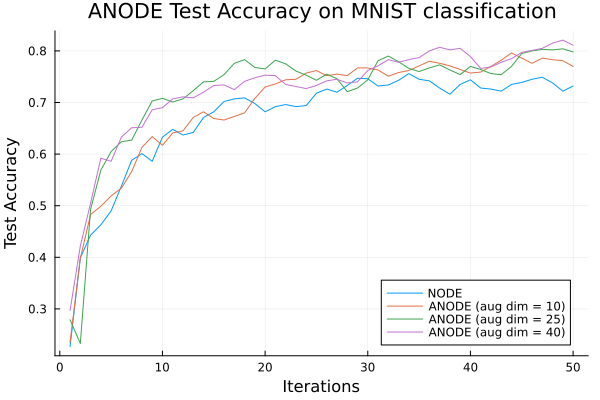

In [188]:
plot(1:50, node_accuracies, label="NODE")
plot!(1:50, anode_accuracies_10, label="ANODE (aug dim = 10)")
plot!(1:50, anode_accuracies_25, label="ANODE (aug dim = 25)")
plot!(1:50, anode_accuracies_40, label="ANODE (aug dim = 40)")
title!("ANODE Test Accuracy on MNIST classification")
xlabel!("Iterations")
ylabel!("Test Accuracy")

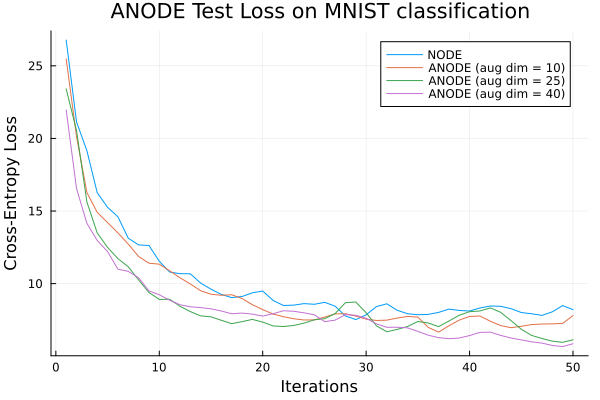

In [189]:
plot(1:50, node_losses, label="NODE")
plot!(1:50, anode_losses_10, label="ANODE (aug dim = 10)")
plot!(1:50, anode_losses_25, label="ANODE (aug dim = 25)")
plot!(1:50, anode_losses_40, label="ANODE (aug dim = 40)")
title!("ANODE Test Loss on MNIST classification")
xlabel!("Iterations")
ylabel!("Cross-Entropy Loss")

## Input-layer augmentation

In [138]:
il_anode_accuracies_10, il_anode_losses_10 = train_mnist_anode(10, input_layer_augmentation=true)

Final accuracy: 0.807

(Any[0.236, 0.342, 0.461, 0.477, 0.556, 0.618, 0.614, 0.63, 0.615, 0.61  …  0.774, 0.798, 0.815, 0.813, 0.806, 0.795, 0.804, 0.813, 0.815, 0.807], Any[26.976202f0, 19.111366f0, 15.211487f0, 13.73826f0, 11.919678f0, 11.102933f0, 10.682887f0, 10.745924f0, 10.585981f0, 10.429465f0  …  7.3744354f0, 6.7953806f0, 6.325192f0, 6.3474174f0, 6.4996414f0, 6.5120573f0, 6.21073f0, 5.9839854f0, 5.9134407f0, 6.1013794f0])

In [132]:
il_anode_accuracies_25, il_anode_losses_25 = train_mnist_anode(25, input_layer_augmentation=true)

Final accuracy: 0.814

(Any[0.339, 0.349, 0.481, 0.502, 0.555, 0.58, 0.603, 0.683, 0.681, 0.654  …  0.804, 0.797, 0.797, 0.791, 0.798, 0.803, 0.813, 0.814, 0.81, 0.814], Any[24.32352f0, 18.394129f0, 14.81003f0, 13.696833f0, 12.909499f0, 12.173111f0, 11.961259f0, 10.760969f0, 10.16151f0, 9.747705f0  …  6.1982403f0, 6.366974f0, 6.520851f0, 6.6333575f0, 6.5653963f0, 6.317669f0, 6.182312f0, 6.120674f0, 6.1274567f0, 6.1962147f0])

In [136]:
il_anode_accuracies_40, il_anode_losses_40 = train_mnist_anode(40, input_layer_augmentation=true)

Final accuracy: 0.823

(Any[0.246, 0.404, 0.495, 0.57, 0.594, 0.592, 0.614, 0.638, 0.678, 0.672  …  0.799, 0.803, 0.806, 0.816, 0.809, 0.809, 0.819, 0.83, 0.825, 0.823], Any[21.776491f0, 18.317554f0, 15.384143f0, 13.855808f0, 12.930713f0, 12.045832f0, 11.108894f0, 10.464067f0, 10.092501f0, 10.068508f0  …  6.5776024f0, 6.4511743f0, 6.0879784f0, 6.0418367f0, 6.0769715f0, 6.0826015f0, 6.0208097f0, 5.6082563f0, 5.6620355f0, 5.829573f0])

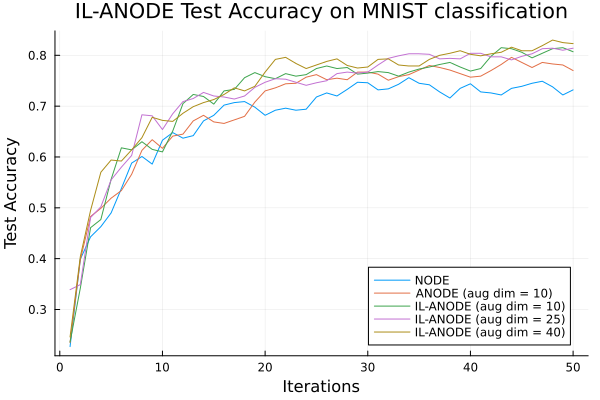

In [190]:
plot(1:50, node_accuracies, label="NODE")
plot!(1:50, anode_accuracies_10, label="ANODE (aug dim = 10)")
plot!(1:50, il_anode_accuracies_10, label="IL-ANODE (aug dim = 10)")
plot!(1:50, il_anode_accuracies_25, label="IL-ANODE (aug dim = 25)")
plot!(1:50, il_anode_accuracies_40, label="IL-ANODE (aug dim = 40)")
title!("IL-ANODE Test Accuracy on MNIST classification")
xlabel!("Iterations")
ylabel!("Test Accuracy")

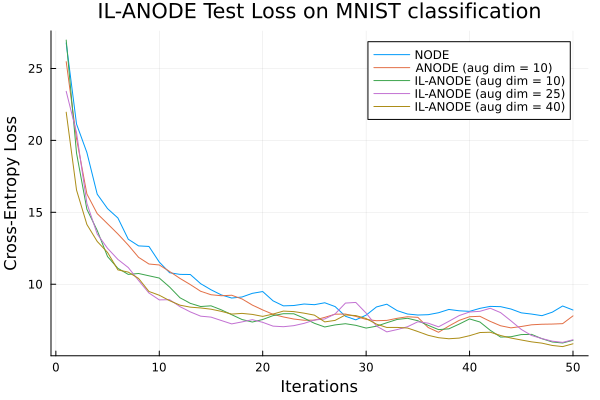

In [191]:
plot(1:50, node_losses, label="NODE")
plot!(1:50, anode_losses_10, label="ANODE (aug dim = 10)")
plot!(1:50, il_anode_losses_10, label="IL-ANODE (aug dim = 10)")
plot!(1:50, anode_losses_25, label="IL-ANODE (aug dim = 25)")
plot!(1:50, anode_losses_40, label="IL-ANODE (aug dim = 40)")
title!("IL-ANODE Test Loss on MNIST classification")
xlabel!("Iterations")
ylabel!("Cross-Entropy Loss")

## Temporal regularization

In [165]:
reg_anode_accuracies_20, reg_anode_losses_20 = train_mnist_anode(10, end_time_regularization=0.2)

Final accuracy: 0.81

(Any[0.424, 0.512, 0.571, 0.626, 0.633, 0.645, 0.657, 0.667, 0.692, 0.705  …  0.812, 0.814, 0.812, 0.809, 0.809, 0.802, 0.795, 0.81, 0.806, 0.81], Any[19.747875f0, 17.554031f0, 14.786218f0, 12.163734f0, 11.380127f0, 10.914139f0, 10.48744f0, 10.126495f0, 9.667911f0, 9.291637f0  …  5.919667f0, 6.081716f0, 6.2100263f0, 6.3855615f0, 6.3893394f0, 6.420374f0, 6.322182f0, 6.232897f0, 6.1347775f0, 6.098957f0])

In [166]:
reg_anode_accuracies_30, reg_anode_losses_30 = train_mnist_anode(10, end_time_regularization=0.3)

Final accuracy: 0.808

(Any[0.357, 0.362, 0.533, 0.575, 0.602, 0.611, 0.63, 0.656, 0.686, 0.697  …  0.79, 0.794, 0.797, 0.805, 0.813, 0.814, 0.809, 0.809, 0.81, 0.808], Any[21.559385f0, 19.332924f0, 15.898358f0, 13.9182625f0, 12.294415f0, 11.268187f0, 10.86916f0, 10.087314f0, 9.530009f0, 9.173318f0  …  6.363705f0, 6.268433f0, 6.068194f0, 5.8814287f0, 5.7526555f0, 5.735334f0, 5.718261f0, 5.8403835f0, 5.9131985f0, 5.9233027f0])

In [181]:
reg_anode_accuracies_60, reg_anode_losses_60 = train_mnist_anode(10, end_time_regularization=0.6)

Final accuracy: 0.821

(Any[0.246, 0.522, 0.58, 0.556, 0.565, 0.592, 0.643, 0.702, 0.697, 0.693  …  0.777, 0.781, 0.79, 0.791, 0.798, 0.8, 0.804, 0.825, 0.821, 0.821], Any[24.08501f0, 15.513119f0, 13.363345f0, 12.5917845f0, 12.221241f0, 11.47541f0, 10.416765f0, 9.56783f0, 9.439296f0, 9.36563f0  …  7.383833f0, 7.5351725f0, 7.1987896f0, 7.0500393f0, 6.9000525f0, 7.007737f0, 6.736189f0, 6.458054f0, 6.536541f0, 6.677477f0])

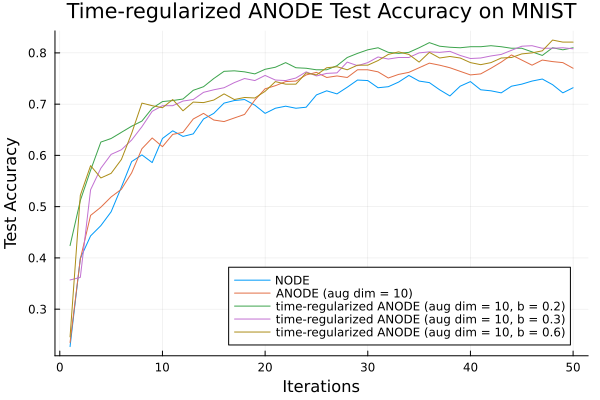

In [195]:
plot(1:50, node_accuracies, label="NODE")
plot!(1:50, anode_accuracies_10, label="ANODE (aug dim = 10)")
plot!(1:50, reg_anode_accuracies_20, label="time-regularized ANODE (aug dim = 10, b = 0.2)")
plot!(1:50, reg_anode_accuracies_30, label="time-regularized ANODE (aug dim = 10, b = 0.3)")
plot!(1:50, reg_anode_accuracies_60, label="time-regularized ANODE (aug dim = 10, b = 0.6)")
title!("Time-regularized ANODE Test Accuracy on MNIST")
xlabel!("Iterations")
ylabel!("Test Accuracy")

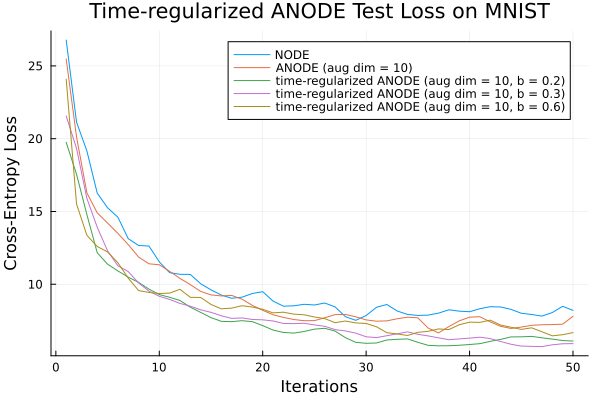

In [217]:
plot(1:50, node_losses, label="NODE")
plot!(1:50, anode_losses_10, label="ANODE (aug dim = 10)")
plot!(1:50, reg_anode_losses_20, label="time-regularized ANODE (aug dim = 10, b = 0.2)")
plot!(1:50, reg_anode_losses_30, label="time-regularized ANODE (aug dim = 10, b = 0.3)")
plot!(1:50, reg_anode_losses_60, label="time-regularized ANODE (aug dim = 10, b = 0.6)")
title!("Time-regularized ANODE Test Loss on MNIST")
xlabel!("Iterations")
ylabel!("Cross-Entropy Loss")

We also compare the train accuracies and losses to see the effect of regularization.

In [203]:
train_anode_accuracies_10, train_anode_losses_10 = train_mnist_anode(10, get_test_acc=false)

Final accuracy: 0.946

(Any[0.241, 0.38, 0.498, 0.604, 0.67, 0.678, 0.651, 0.699, 0.721, 0.754  …  0.918, 0.914, 0.917, 0.937, 0.94, 0.934, 0.935, 0.934, 0.942, 0.946], Any[23.077784f0, 20.176426f0, 14.558219f0, 12.5663185f0, 10.771791f0, 9.7211075f0, 9.553288f0, 8.889776f0, 8.6946335f0, 7.9237175f0  …  2.532746f0, 2.6941848f0, 2.579479f0, 2.269206f0, 2.2287428f0, 2.3123062f0, 2.4240556f0, 2.3259807f0, 2.1167514f0, 2.0490487f0])

In [212]:
train_reg_anode_accuracies_20, train_reg_anode_losses_20 = train_mnist_anode(10, end_time_regularization=0.2, get_test_acc=false)

Final accuracy: 0.938

(Any[0.111, 0.41, 0.462, 0.5, 0.498, 0.521, 0.581, 0.612, 0.618, 0.653  …  0.919, 0.915, 0.914, 0.919, 0.925, 0.925, 0.933, 0.937, 0.937, 0.938], Any[30.930473f0, 17.823364f0, 15.5176525f0, 15.553515f0, 14.845526f0, 13.960464f0, 12.671738f0, 11.6204605f0, 10.699567f0, 9.843736f0  …  3.1395802f0, 3.1099803f0, 3.0403104f0, 2.9484227f0, 2.7943244f0, 2.6481507f0, 2.5220902f0, 2.4438884f0, 2.3126972f0, 2.3128533f0])

In [199]:
train_reg_anode_accuracies_30, train_reg_anode_losses_30 = train_mnist_anode(10, end_time_regularization=0.3, get_test_acc=false)

Final accuracy: 0.904

(Any[0.197, 0.304, 0.386, 0.484, 0.549, 0.597, 0.592, 0.583, 0.581, 0.597  …  0.885, 0.883, 0.88, 0.885, 0.893, 0.902, 0.908, 0.915, 0.923, 0.904], Any[31.288296f0, 22.87244f0, 18.19588f0, 15.995473f0, 14.732131f0, 13.929122f0, 13.421138f0, 12.851914f0, 12.369618f0, 11.980809f0  …  3.9037642f0, 3.8571222f0, 3.7724004f0, 3.7433622f0, 3.7173815f0, 3.5264835f0, 3.349937f0, 3.0599642f0, 2.924942f0, 3.1416585f0])

In [207]:
train_reg_anode_accuracies_60, train_reg_anode_losses_60 = train_mnist_anode(10, end_time_regularization=0.6, get_test_acc=false)

Final accuracy: 0.926

(Any[0.182, 0.455, 0.51, 0.557, 0.636, 0.623, 0.619, 0.67, 0.706, 0.719  …  0.906, 0.901, 0.907, 0.906, 0.916, 0.922, 0.928, 0.932, 0.929, 0.926], Any[25.784758f0, 18.008217f0, 14.987472f0, 12.914676f0, 11.863629f0, 11.472921f0, 10.8568535f0, 10.073899f0, 9.285956f0, 8.785873f0  …  3.2794962f0, 3.2985308f0, 3.3525686f0, 3.2584991f0, 3.0158727f0, 2.7157683f0, 2.5784726f0, 2.5748463f0, 2.6814878f0, 2.6752093f0])

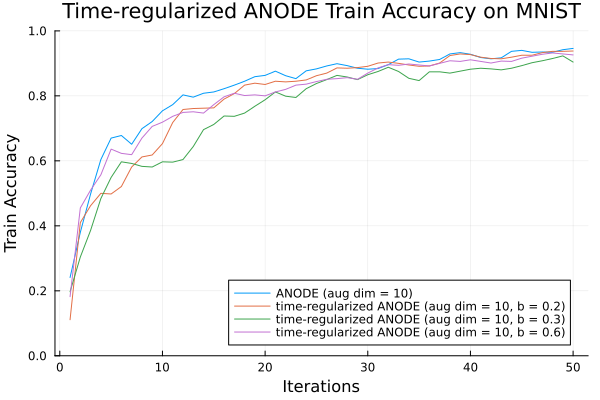

In [215]:
plot(1:50, train_anode_accuracies_10, label="ANODE (aug dim = 10)", ylims=(0, 1))
plot!(1:50, train_reg_anode_accuracies_20, label="time-regularized ANODE (aug dim = 10, b = 0.2)")
plot!(1:50, train_reg_anode_accuracies_30, label="time-regularized ANODE (aug dim = 10, b = 0.3)")
plot!(1:50, train_reg_anode_accuracies_60, label="time-regularized ANODE (aug dim = 10, b = 0.6)")
title!("Time-regularized ANODE Train Accuracy on MNIST")
xlabel!("Iterations")
ylabel!("Train Accuracy")

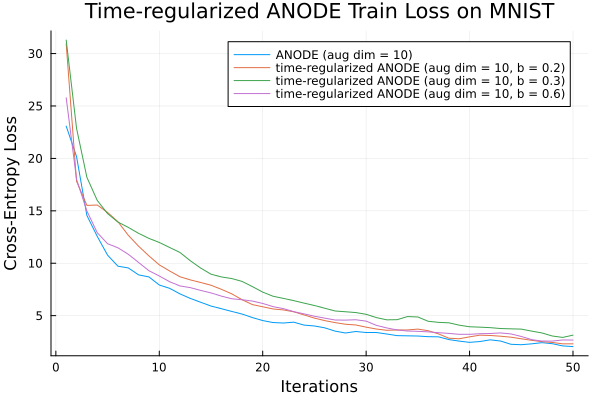

In [219]:
plot(1:50, train_anode_losses_10, label="ANODE (aug dim = 10)")
plot!(1:50, train_reg_anode_losses_20, label="time-regularized ANODE (aug dim = 10, b = 0.2)")
plot!(1:50, train_reg_anode_losses_30, label="time-regularized ANODE (aug dim = 10, b = 0.3)")
plot!(1:50, train_reg_anode_losses_60, label="time-regularized ANODE (aug dim = 10, b = 0.6)")
title!("Time-regularized ANODE Train Loss on MNIST")
xlabel!("Iterations")
ylabel!("Cross-Entropy Loss")

## Second order NODEs

In [274]:
second_order_node_accuracies_0, second_order_node_losses_0 = train_mnist_anode(0, second_order=true)

Final accuracy: 0.554

(Any[0.109, 0.088, 0.116, 0.122, 0.226, 0.291, 0.309, 0.334, 0.379, 0.372  …  0.529, 0.526, 0.541, 0.537, 0.553, 0.538, 0.528, 0.532, 0.549, 0.554], Any[41.822056f0, 39.741383f0, 27.164011f0, 24.48871f0, 25.409086f0, 24.552261f0, 22.998236f0, 21.447826f0, 19.802427f0, 18.352165f0  …  14.319466f0, 14.668753f0, 14.380504f0, 13.760771f0, 13.430332f0, 13.577651f0, 13.909873f0, 13.633666f0, 13.377003f0, 13.244428f0])

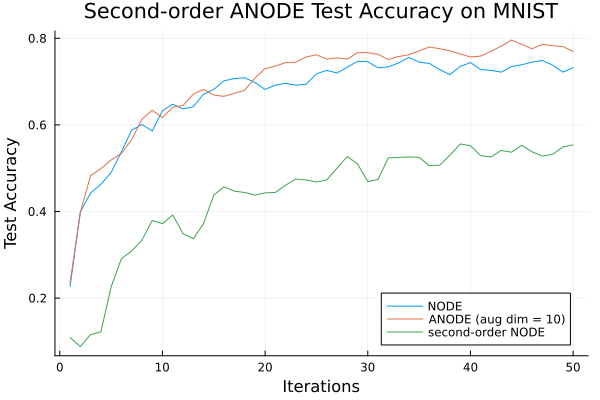

In [284]:
plot(1:50, node_accuracies, label="NODE")
plot!(1:50, anode_accuracies_10, label="ANODE (aug dim = 10)")
plot!(1:50, second_order_node_accuracies_0, label="second-order NODE")
title!("Second-order ANODE Test Accuracy on MNIST")
xlabel!("Iterations")
ylabel!("Test Accuracy")

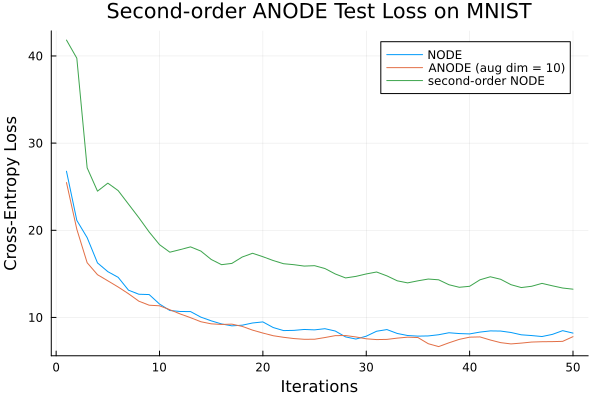

In [285]:
plot(1:50, node_losses, label="NODE")
plot!(1:50, anode_losses_10, label="ANODE (aug dim = 10)")
plot!(1:50, second_order_node_losses_0, label="second-order NODE")
title!("Second-order ANODE Test Loss on MNIST")
xlabel!("Iterations")
ylabel!("Cross-Entropy Loss")